Will use device: cpu, torch dtype: torch.float32


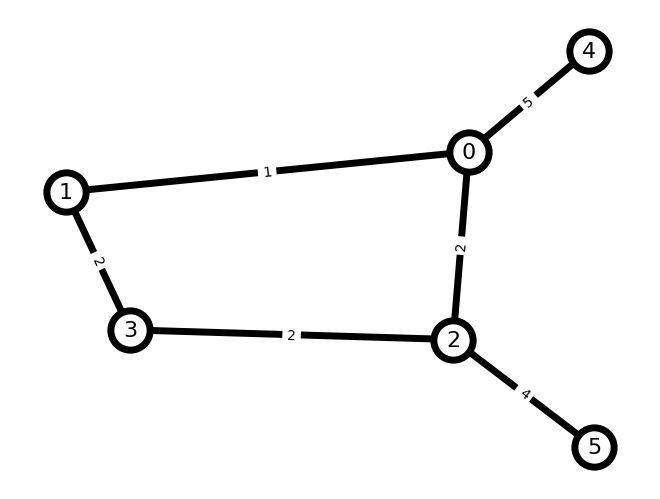

In [1]:
from GraphCreator import *

In [2]:
def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight']
        adj_dict[(v, u)] = nx_G[u][v]['weight']

    for u in nx_G.nodes:
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0

    return adj_dict

def DrawGraph(graph):
    pos = nx.spring_layout(graph,seed=1)

    # Visualize graph
    options = {
        "font_size": 16,
        "node_size": 800,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 5,
        "width": 5,
    }
    nx.draw(graph, pos, with_labels=True, **options)

    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

def CreateDummyFunction(edges):
    test_graph = nx.Graph()
    test_graph.add_edges_from(edges)
    test_graph.order()
    return test_graph

def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat

def calculateMinCut(adj_matrix, output, terminal1 = 0, terminal2 = 4):
    #output = (output.detach() >= 0.5) * 1

    # if output[terminal1] == output[terminal2]:
    #     return float("inf")
    #print(adj_matrix, output)
    loss = 0
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if (output[i] > 0.5 and output[j] < 0.5) or (output[i] < 0.5 and output[j] > 0.5) :
                loss+=adj_matrix[i][j]

    return loss

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * partition_matrix).sum() / 2
    return weight

def expected_partition_weight(adj, s):
    """
    Calculates the expected sum of weights of edges that are in different partitions,
    based on the probabilities in s.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the probability of each edge being in a certain partition.
    :return: Expected sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.outer(s, 1 - s) + np.outer(1 - s, s)
    expected_weight = (adj * partition_matrix).sum() / 2
    return expected_weight

# Hamiltonian Partitioning
We are going to experiment with hamilotnian paritioning on couple of graphs and adjacent matrix to see how well it works

In [3]:
def Hamiltonian(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    #HA = ((s.sum() ** 2) if len(s) % 2 == 0 else ((s.sum() ** 2) / 2))
    HA = ((np.sum(s)** 2) if len(s) % 2 == 0 else ((np.sum(s) ** 2) / 2))

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - np.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def HamiltonianLoss(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    HA = ((s.sum() ** 2) if len(s) % 2 == 0 else ((s.sum() ** 2) / 2))

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - torch.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def HamiltonianLoss2(s, w, A = 9, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    num_nodes = s.size(0)
    ideal_balance = num_nodes / 2.0

    # HA is a penalty term for the deviation of sum of probabilities from the ideal balance
    HA = (torch.sum(s) - ideal_balance) ** 2

    # Calculate HB
    # HB = np.sum(w * (1 - np.outer(s, s)) / 2)

    HB = (w * (1 - torch.outer(s, s)) / 2).sum()
    # Hamiltonian H
    H = A * HA + B * HB

    return H


def HamiltonianLoss3(s, w, A = 1, B = 1):
    '''

    :param s: In original H paritioning, s is either 1 or -1
    :param w: The adjacent matrix of the graph
    :param A: a hyper parameter
    :param B: another hyper parameter
    :return:
    '''

    # Calculate HA
    num_nodes = s.size(0)
    ideal_balance = num_nodes / 2.0

    # HA is a penalty term for the deviation of sum of probabilities from the ideal balance
    HA = (torch.sum(s) - ideal_balance) ** 2

    HB = expected_partition_weight2(w, s)
    # Hamiltonian H
    H = A * HA + B * HB

    return H

def expected_partition_weight2(adj, s):
    """
    Calculates the expected sum of weights of edges that are in different partitions,
    based on the probabilities in s.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the probability of each edge being in a certain partition.
    :return: Expected sum of weights of edges in different partitions.
    """
    #s = torch.array(s)
    partition_matrix = torch.outer(s, 1 - s) + torch.outer(1 - s, s)
    expected_weight = (adj * partition_matrix).sum() / 2

    # # Penalty term
    # edge_probs = s[list((0,4))]
    # penalty = 10 * torch.prod(edge_probs) + 10 * torch.prod(1 - edge_probs)
    # expected_weight += penalty
    return expected_weight

# Experiment with H partitiioning

We are going to run H paritioning on some graphs with different s values. Lets talk our first graph:

## Graph 1
Vertex 0 --(1)-- Vertex 1
  |     \
  |       \
 (3)      (2)
  |          \
  |            \
Vertex 2 --(1)-- Vertex 3



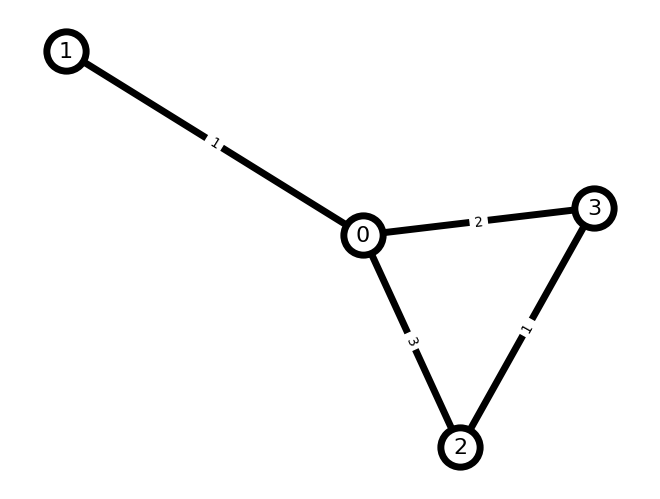

In [4]:
edges = [(0,1, {"weight": 1, "capacity":1}),
         (0,2, {"weight": 3, "capacity":3}),
         (0,3, {"weight": 2, "capacity":2}),
         (2,3, {"weight": 1, "capacity":1})]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
DrawGraph(graph)

In [5]:
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
q_torch

tensor([[0., 1., 3., 2.],
        [1., 0., 0., 0.],
        [3., 0., 0., 1.],
        [2., 0., 1., 0.]])

In [6]:
possible_combo = [np.array([1, 1, 1, -1]),np.array([1, 1, -1, -1]), np.array([1, -1, -1, -1]), np.array([-1, -1, -1, -1]),
                  np.array([1, 1, -1, 1]), np.array([1, -1, 1, 1]), np.array([-1, 1, 1, 1]), np.array([1, -1, 1, -1]), np.array([-1, 1, -1, 1]),
                  np.array([1, 1, 1, 1])]

for i in possible_combo:
    hamiltonian = Hamiltonian(i, q_torch)
    spins = [1 if m > 0.5 else 0 for m in i]
    calc = calculateMinCut(q_torch, spins)

    print(hamiltonian, calc/2, ((q_torch * (1 - np.outer(spins, spins)) / 2).sum()/2))
print('-------')
# for i in possible_combo:
#     spins = [1 if m > 0.5 else 0 for m in i]
#     hamiltonian = Hamiltonian(spins, q_torch)
#     calc = calculateMinCut(q_torch, spins)
#
#     print(hamiltonian, calc/2)
print('-------')
for i in possible_combo:
    spins = torch.FloatTensor([1 if m > 0.5 else 0 for m in i])
    hamiltonian = HamiltonianLoss2(spins, q_torch)
    calc = calculateMinCut(q_torch, spins)

    print(hamiltonian, calc/2, ((q_torch * (1 - np.outer(spins, spins)) / 2).sum()/2))

tensor(10., dtype=torch.float64) tensor(3.) tensor(1.5000, dtype=torch.float64)
tensor(10., dtype=torch.float64) tensor(5.) tensor(3., dtype=torch.float64)
tensor(16., dtype=torch.float64) tensor(6.) tensor(3.5000, dtype=torch.float64)
tensor(16., dtype=torch.float64) 0.0 tensor(3.5000, dtype=torch.float64)
tensor(12., dtype=torch.float64) tensor(4.) tensor(2., dtype=torch.float64)
tensor(6., dtype=torch.float64) tensor(1.) tensor(0.5000, dtype=torch.float64)
tensor(16., dtype=torch.float64) tensor(6.) tensor(3., dtype=torch.float64)
tensor(8., dtype=torch.float64) tensor(4.) tensor(2., dtype=torch.float64)
tensor(8., dtype=torch.float64) tensor(4.) tensor(3.5000, dtype=torch.float64)
tensor(16., dtype=torch.float64) 0.0 tensor(0., dtype=torch.float64)
-------
-------
tensor(12.) tensor(3.) tensor(1.5000)
tensor(6.) tensor(5.) tensor(3.)
tensor(16.) tensor(6.) tensor(3.5000)
tensor(43.) 0.0 tensor(3.5000)
tensor(13.) tensor(4.) tensor(2.)
tensor(10.) tensor(1.) tensor(0.5000)
tensor(15

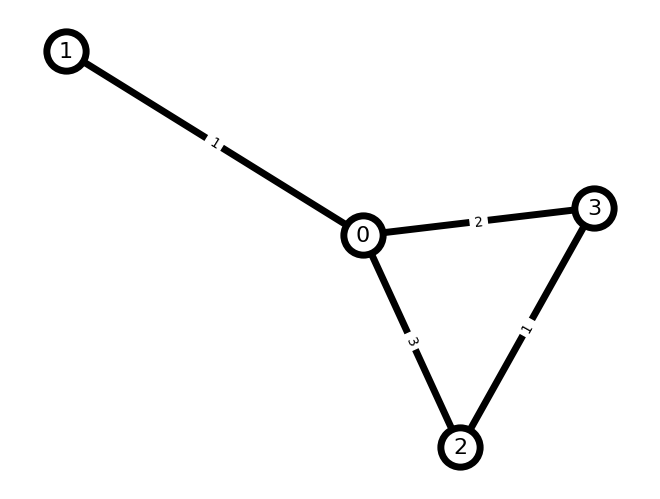

In [7]:
DrawGraph(graph)

## Example 2


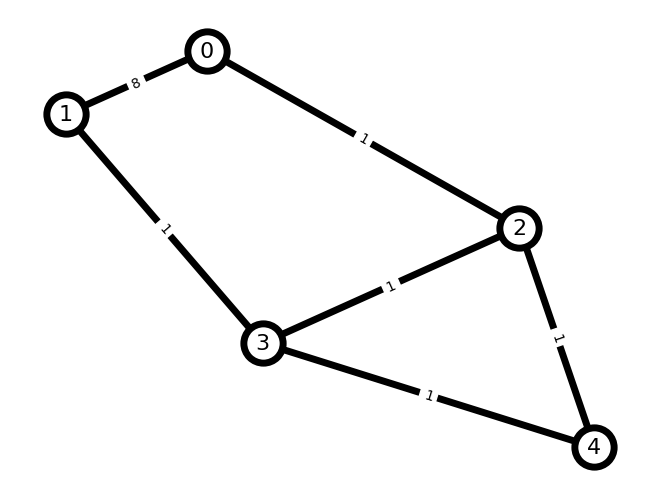

In [8]:
edges = [(0,1, {"weight": 8, "capacity":8}),
        (0,2, {"weight": 1, "capacity":1}),
        (1,3, {"weight": 1, "capacity":1}),
        (2,3, {"weight": 1, "capacity":1}),
        (2,4, {"weight": 1, "capacity":1}),
        (3,4, {"weight": 1, "capacity":1})]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
DrawGraph(graph)

In [9]:
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
q_torch

tensor([[0., 8., 1., 0., 0.],
        [8., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0.]])

In [10]:
possible_combo = [np.array([1, 1, 1, -1, 1]),np.array([1, 1, -1, -1, 1]), np.array([1, -1, -1, -1, 1]), np.array([-1, -1, -1, -1, 1]),
                  np.array([1, 1, -1, 1, 1]), np.array([1, -1, 1, 1, 1]), np.array([-1, 1, 1, 1, 1]), np.array([1, -1, 1, -1, 1]),
                  np.array([-1, 1, -1, 1, 1]), np.array([-1, -1, 1, 1, 1]), np.array([1, 1, 1, 1, 1]), np.array([1, -1, -1, 1, 1])]

for i in possible_combo:
    hamiltonian = Hamiltonian(i, q_torch)
    spins = [1 if m > 0.5 else 0 for m in i]
    calc = calculateMinCut(q_torch, spins)

    print(hamiltonian, calc/2, ((q_torch * (1 - np.outer(spins, spins)) / 2).sum()/2))
print('-----')
for i in possible_combo:
    spins = torch.FloatTensor([1 if m > 0.5 else 0 for m in i])
    hamiltonian = HamiltonianLoss2(spins, q_torch)
    calc = calculateMinCut(q_torch, spins)

    print(hamiltonian, calc/2,
          ((q_torch * (1 - np.outer(i, i)) / 2).sum())/2, partition_weight(q_torch, spins))

tensor(10.5000, dtype=torch.float64) tensor(3.) tensor(1.5000, dtype=torch.float64)
tensor(8.5000, dtype=torch.float64) tensor(4.) tensor(2.5000, dtype=torch.float64)
tensor(22.5000, dtype=torch.float64) tensor(11.) tensor(6.5000, dtype=torch.float64)
tensor(8.5000, dtype=torch.float64) tensor(2.) tensor(6.5000, dtype=torch.float64)
tensor(10.5000, dtype=torch.float64) tensor(3.) tensor(1.5000, dtype=torch.float64)
tensor(22.5000, dtype=torch.float64) tensor(9.) tensor(4.5000, dtype=torch.float64)
tensor(22.5000, dtype=torch.float64) tensor(9.) tensor(4.5000, dtype=torch.float64)
tensor(20.5000, dtype=torch.float64) tensor(10.) tensor(5.5000, dtype=torch.float64)
tensor(20.5000, dtype=torch.float64) tensor(10.) tensor(5.5000, dtype=torch.float64)
tensor(4.5000, dtype=torch.float64) tensor(2.) tensor(5., dtype=torch.float64)
tensor(12.5000, dtype=torch.float64) 0.0 tensor(0., dtype=torch.float64)
tensor(24.5000, dtype=torch.float64) tensor(12.) tensor(6., dtype=torch.float64)
-----
tens

# Neural Network Code

Neural Network Architecture

In [11]:
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h

In [12]:
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

In [25]:
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        calc = partition_weight(q_torch, bitstring)
        # if loss < best_loss:
        #     best_loss = loss
        #     best_bitstring = bitstring

        if calc < best_loss and calc != 0:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print(probs, q_torch)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring
def run_gnn_training2(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    prev_loss = 1.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model

        # build cost value with QUBO cost function
        loss = loss_func(probs, q_torch)
        loss_ = loss.detach().item()

        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        calc = partition_weight(q_torch, bitstring)
        # if loss < best_loss:
        #     best_loss = loss
        #     best_bitstring = bitstring
        #add reward
        loss = loss-calc

        if calc < best_loss and calc != 0:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print(probs, q_torch)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            break

        # update loss tracking
        prev_loss = loss_

        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        loss.backward()        # calculate gradient through compute graph
        optimizer.step()       # take step, update weights

    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring

In [15]:
def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = int(np.sqrt(n))    # e.g. 10
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

# Training GCN on graph 2

In [26]:
edges = [(0,1, {"weight": 8, "capacity":8}),
         (0,2, {"weight": 1, "capacity":1}),
         (1,3, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (2,4, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 1, "capacity":1})]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=5,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [27]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], HamiltonianLoss2)

calc = calculateMinCut(q_torch, best_bitstring)
gnn_time = time() - gnn_start
final_bitstring, best_bitstring, calc/2, (q_torch * (1 - np.outer(best_bitstring, best_bitstring)) / 2).sum()

Running GNN...


KeyboardInterrupt: 

In [561]:
final_bitstring, best_bitstring, calc/2, (q_torch * (1 - np.outer(best_bitstring, best_bitstring)) / 2).sum(), \
partition_weight(q_torch, best_bitstring), HamiltonianLoss2(best_bitstring, q_torch)

print("Final Cut LOSS:" + str(partition_weight(q_torch, best_bitstring).item()), "partition is:" + str(best_bitstring))

Final Cut LOSS:4.0 partition is:tensor([1, 1, 0, 0, 1])


# Training GCN on graph 1

In [556]:
edges = [(0,1, {"weight": 1, "capacity":1}),
         (0,2, {"weight": 3, "capacity":3}),
         (0,3, {"weight": 2, "capacity":2}),
         (2,3, {"weight": 1, "capacity":1})]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4,patience=10000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [557]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], HamiltonianLoss2)

calc = calculateMinCut(q_torch, best_bitstring)
gnn_time = time() - gnn_start
final_bitstring, best_bitstring, calc/2, (q_torch * (1 - np.outer(best_bitstring, best_bitstring)) / 2).sum()

Running GNN...
Epoch: 0, Loss: 5.331417560577393
tensor([0.5000, 0.4798, 0.4857, 0.4857], grad_fn=<SelectBackward0>) tensor([[0., 1., 3., 2.],
        [1., 0., 0., 0.],
        [3., 0., 0., 1.],
        [2., 0., 1., 0.]])
Epoch: 1000, Loss: 5.170248031616211
tensor([0.5171, 0.5171, 0.5171, 0.5171], grad_fn=<SelectBackward0>) tensor([[0., 1., 3., 2.],
        [1., 0., 0., 0.],
        [3., 0., 0., 1.],
        [2., 0., 1., 0.]])
Epoch: 2000, Loss: 5.160765647888184
tensor([0.5244, 0.5244, 0.5244, 0.5244], grad_fn=<SelectBackward0>) tensor([[0., 1., 3., 2.],
        [1., 0., 0., 0.],
        [3., 0., 0., 1.],
        [2., 0., 1., 0.]])
Epoch: 3000, Loss: 5.160584449768066
tensor([0.5255, 0.5255, 0.5255, 0.5255], grad_fn=<SelectBackward0>) tensor([[0., 1., 3., 2.],
        [1., 0., 0., 0.],
        [3., 0., 0., 1.],
        [2., 0., 1., 0.]])
Epoch: 4000, Loss: 5.16058349609375
tensor([0.5255, 0.5255, 0.5255, 0.5255], grad_fn=<SelectBackward0>) tensor([[0., 1., 3., 2.],
        [1., 0., 0

(tensor([1, 1, 1, 1]),
 tensor([1, 0, 1, 1]),
 tensor(1.),
 tensor(1., dtype=torch.float64))

In [558]:
final_bitstring, best_bitstring, calc/2, (q_torch * (1 - np.outer(best_bitstring, best_bitstring)) / 2).sum(), \
partition_weight(q_torch, best_bitstring), HamiltonianLoss2(best_bitstring, q_torch)

print("Final Cut LOSS:" + str(partition_weight(q_torch, best_bitstring).item()), "partition is:" + str(best_bitstring))

Final Cut LOSS:1.0 partition is:tensor([1, 0, 1, 1])
